In [16]:
import random
from collections import namedtuple, deque
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import gymnasium
import cv2
from PIL import Image, ImageDraw
import os
from sklearn.metrics import confusion_matrix
import copy #Импортируем библиотеку для ранней остановки

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 1e-4 #скорость обучения CNN
NUM_CLASSES = 10
IMG_SIZE = 128
NUM_IMAGES = 50000
MAX_SUBSET_SIZE = 1000 #количество изображений в выборке
CNN_EPOCHS = 2

EPS_START = 0.9#стартовое значение epsilon для e-greedy стратегии
EPS_END = 0.05#конечное значение
EPS_DECAY = 200 #скорость изменения epsilon
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [18]:
class DataSet():
    def __init__(self):# 1. Параметры генератора
        self.CELL_COUNT_RANGE = (1, 10)  # Количество клеток на изображение (минимум, максимум)
        self.CELL_SIZE_RANGE = (5, 15)  # Диаметр клеток (минимум, максимум)
        self.CELL_COLOR_RANGE = ((100, 0, 0), (255, 100, 100))  # Цвет клеток (минимум, максимум по BGR)
        self.BACKGROUND_COLOR = (247, 131, 243)  # Розовый фон
        self.OVERLAP_PROBABILITY = 0.1  # Вероятность перекрытия клетки с другой

    def random_color(self, color_range):
        """Генерирует случайный цвет в заданном диапазоне."""
        return tuple(random.randint(color_range[0][i], color_range[1][i]) for i in range(3))

    def generate_blood_cell_image(self):
        """Генерирует одно изображение с клетками крови."""
        image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), self.BACKGROUND_COLOR)
        draw = ImageDraw.Draw(image)
        cell_count = random.randint(self.CELL_COUNT_RANGE[0], self.CELL_COUNT_RANGE[1])
        cells = []  # Список координат и размеров клеток, чтобы отслеживать перекрытия

        for _ in range(cell_count):
            cell_size = random.randint(self.CELL_SIZE_RANGE[0], self.CELL_SIZE_RANGE[1])

            # Попробуем найти позицию для клетки, чтобы избежать перекрытия (если OVERLAP_PROBABILITY низкая)
            max_attempts = 100
            for attempt in range(max_attempts):
                x = random.randint(cell_size, IMG_SIZE - cell_size)
                y = random.randint(cell_size, IMG_SIZE - cell_size)

                # Проверяем, перекрывается ли новая клетка с существующими
                overlap = False
                if random.random() > self.OVERLAP_PROBABILITY: # Проверяем, нужно ли вообще проверять перекрытие
                    for existing_x, existing_y, existing_size in cells:
                        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)
                        if distance < (cell_size + existing_size) * 0.7:  # Уменьшил коэфф. для допущения небольшого перекрытия
                            overlap = True
                            break

                if not overlap:
                    break # Нашли подходящую позицию

            if overlap and attempt == max_attempts-1 :
                #Если не нашли хорошую позицию, то игнорируем данную клетку
                continue


            cell_color = self.random_color(self.CELL_COLOR_RANGE)
            draw.ellipse((x - cell_size, y - cell_size, x + cell_size, y + cell_size), fill=cell_color)
            cells.append((x, y, cell_size))

        return np.array(image), cell_count

    def generate_dataset(self,num_images, output_dir="blood_cell_dataset"):
        """Генерирует набор данных изображений и меток."""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        images = []
        labels = []

        for i in range(num_images):
            image, cell_count = self.generate_blood_cell_image()
            images.append(image)
            labels.append(cell_count) #label-1 to make 0 index

            # Сохранение изображений (опционально)
            #image_path = os.path.join(output_dir, f"image_{i}.png")
           # cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convert to BGR for OpenCV

        return images, labels


In [ ]:
def get_dataloader(subset, shuffle=True):
    return DataLoader(subset, batch_size=BATCH_SIZE, shuffle=shuffle)


In [ ]:
class Flatten(nn.Module):
    def forward(self, batch):
        return batch.reshape(batch.size(0), -1)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
       # self.dropout = nn.Dropout(0.25) # Dropout
        self.flatten = Flatten()
        self.fc1 = nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.bn1(self.cv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.cv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.cv3(x)))
        x = self.pool(x)
        x = self.flatten(x)
       # x = self.dropout(x)  # Применяем Dropout перед полносвязными слоями
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [21]:
class BloodCellDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        #self.images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]  # Преобразуем в градации серого
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        #image = np.expand_dims(image, axis=0)  # Добавляем канал (1, H, W)

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1) # Convert to float and permute
        return image, torch.tensor(label, dtype=torch.long)


In [22]:
class DataPreloading():
    def __init__(self, num_samples=NUM_IMAGES):
        self.dataset_generator = DataSet()
        images, labels = self.dataset_generator.generate_dataset(num_samples)

        self.dataset = BloodCellDataset(images, labels)
    def get_train_data(self):
        return self.dataset

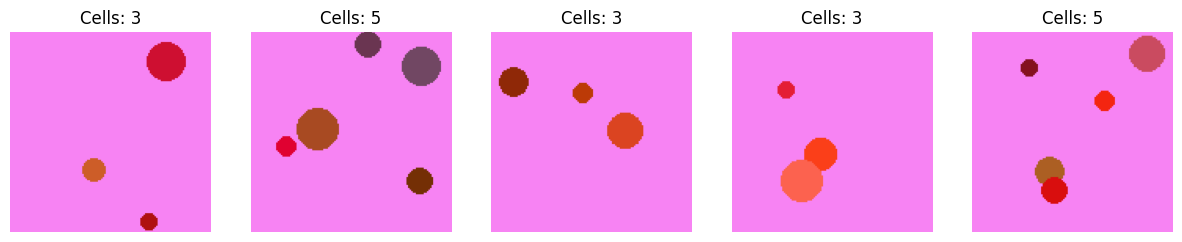

In [23]:
train_data = DataPreloading(num_samples=100).get_train_data()
# 5. Визуализация
import matplotlib.pyplot as plt

def visualize_data(images, labels, num_samples=5):
    """Визуализирует несколько случайных изображений из набора данных."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        index = random.randint(0, len(images) - 1)
        axes[i].imshow(images[index])
        axes[i].set_title(f"Cells: {labels[index]}")
        axes[i].axis('off')
    plt.show()

visualize_data(train_data.images, train_data.labels)

In [24]:
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class DataSelectionEnv(gymnasium.Env):
    def __init__(self):
        super(DataSelectionEnv, self).__init__()
        self.train_data = DataPreloading(num_samples=NUM_IMAGES).get_train_data()
        self.model = SimpleCNN().to(DEVICE) 
        self.criterion = nn.CrossEntropyLoss()
        self.indexes = self.class_select()
        self.optim = optim.Adam(self.model.parameters(), lr=LEARNING_RATE) #пробовал добавлять weight_decay

        # Пространство действий: вероятности выбора изображений для каждого класса
        self.action_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)
        self.observation_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)

        #validation set
        self.validation_indices = random.sample(range(len(self.train_data)), int(0.2 * len(self.train_data)))
        self.validation_subset = Subset(self.train_data, self.validation_indices)
        self.validation_dataloader = get_dataloader(self.validation_subset, shuffle=False)

    def class_select(self):#возвращаем словарь из индексов принадлежащим классам
        ls = {i: [] for i in range(NUM_CLASSES)} #создали пустой словарь на 10 классов

        for x, (image, label) in enumerate(self.train_data): #unpack both
            label_value = label.item()-1 #значения меток начинаются с 1, а индексация с 0
            ls[label_value].append(x) #индекс каждого изображения из train_data положили в нужный класс в зависимости от метки

        return ls

    def sample(self, action):#action - тензор распределения процентов изображений от каждого класса в выборке
        action = np.clip(action, 0, 1) #clip the action
        action = action / np.sum(action) #renormalize to ensure sum = 1
        index = []

        for i in range(NUM_CLASSES):
            num_img = int(action[i] * MAX_SUBSET_SIZE) #определили количество изображений для i-го класса в выборке из batch_size изображений
            indexes = np.random.choice(self.indexes[i], num_img, replace=True) #рандомно выбираем вычисленное количество изображений из изображений нужного класса, возвращаем их индексы
            index.extend(indexes)#добавляем найденные индексы в выборку

        return Subset(self.train_data, index)#состовляем subset

    def step(self, action,weights):
        # в этой функции мы создаем выборку на основе action и проверяем, насколько улучшилось или ухудшилось предсказание сети
        #action = np.clip(action + np.random.uniform(-0.05, 0.05, size=action.shape), 0, 1)
        train_subset = self.sample(action) #subset - выбранное случайное подмножество из 32 элементов на основе распределения action
        train_dataloader = get_dataloader(train_subset) #создали dataloader, выдающий этот batch из 32 элементов
        #prev_acc, _ = self.evaluate(test_dataloader) #вычиляем текущую точность модели на тестовой выборке
        self.train_model(train_dataloader, epochs=CNN_EPOCHS) #тренируем модель на тренировчной выборке
        _, err_per_cl = self.evaluate(self.validation_dataloader)  # Теперь возвращается точность по классам
        
        reward = np.sum([(1- err_per_cl[i])*weights[i] for i in range(NUM_CLASSES)])
        #reward = new_acc - self.last_acc #Предыдущая награда

        return reward, err_per_cl

    def train_model(self, dataloader, epochs=1):
        # на вход приходит dataloader выдающий batch изображений и ответов к ним
        self.model.train()#Необходимо переводить в train
        for epoch in range(epochs):
            for images, labels in dataloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                self.optim.zero_grad() #обновили optimizer
                output = self.model(images) #получили тензор(batch_size, NUM_CLASSES) с распределением вероятностей для каждого изображения
                
                loss = self.criterion(output, labels-1) #вычислили ошибку с помощью CrossEntropyLoss\
                print("loss = ", loss)
                loss.backward()
                self.optim.step()



    def evaluate(self, dataloader):
        self.model.eval()  # Переводим модель в оценочный режим
        correct = 0
        total = 0
        ls = torch.zeros(NUM_CLASSES, dtype=torch.int64, device=DEVICE)
        ers = torch.zeros(NUM_CLASSES, dtype=torch.int64, device=DEVICE)

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = self.model(images)  # Получили тензор(batch_size,NUM_CLASSES)
                predicted = torch.argmax(output, dim=1)+1  # Получили тезор(batch_size)
                correct += (predicted == labels).sum().item()  # Нашли количество правильных ответов
                total += labels.size(0) 

                # Обновляем ls и ers
                for i in range(NUM_CLASSES):
                    ls[i] += (labels == i+1).sum()
                    ers[i] += ((labels == i+1) & (predicted != labels)).sum()

        # Вычисляем error_per_class, обрабатывая деление на ноль
        error_per_class = [(ers[i].float() / ls[i].float()).item() if ls[i] > 0 else 0 for i in range(NUM_CLASSES)]

        accuracy = (correct / total) if total > 0 else 0  # Находим точность на данной выборке
        print("accuracy = ", accuracy)
        return accuracy, error_per_class


In [ ]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

class replay_memory(object):
    def __init__(self,capacity):
        self.memory = deque([],maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)  

In [27]:
import torch.profiler as profiler
prof = profiler.profile(
    schedule=profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log'),
    record_shapes=True,
    profile_memory=True,
    with_stack=True
)

In [ ]:
def calculate_class_values(error_per_class):#функция для вычисления весов классов по ошибке на них
    """Вычисляет ценность классов на основе ошибок."""
    class_values = [min(1.0 / (1 - error + 1e-6), 10) for error in error_per_class]  # Избегаем деления на 0
    return class_values

In [ ]:
def actor_critic(env, actor, critic, episodes=10, max_steps=100, gamma=0.99, lr_actor=1e-2, lr_critic=1e-2):
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)

    actor.to(DEVICE)
    critic.to(DEVICE)
    memory = replay_memory(10000)
    # Create test set outside the loop for consistency
    test_dataset = DataPreloading().get_train_data()  # Get the full training data
    test_indices = random.sample(range(len(test_dataset)), int(0.2 * len(test_dataset)))  # 20% for test
    test_subset = Subset(test_dataset, test_indices)
    test_dataloader = get_dataloader(test_subset, shuffle=False)

    steps_done = 0
    best_val_accuracy = float('-inf')  # Начальное значение (отрицательная бесконечность)
    patience = 30  # Окно терпения (количество шагов без улучшений)
    counter = 0  # Счетчик эпох без улучшений
    best_model_state = None #Сохраняем модель с наилучшей точностью
    with prof:
        for episode in range(episodes):
            state = np.ones(NUM_CLASSES) / NUM_CLASSES #массив ошибок по классам
            action = np.zeros(NUM_CLASSES) #распределение процентов количества изображений из каждого класса в выборке
            state_tensor = torch.FloatTensor(state).to(DEVICE)
            step = 0
            while step < max_steps:
                step += 1
                steps_done += 1  # Увеличиваем steps_done здесь, до использования

                print(f"Episode: {episode+1}, Step: {step}, State: {state}")
                weights = calculate_class_values(state)
                print("weights",weights)
                epsilon = EPS_END + (EPS_START - EPS_END)*math.exp(-1*steps_done/EPS_DECAY)
                print(f"Episode: {episode+1}, Step: {step}, Epsilon: {epsilon:.4f}")
                #выбираем действие
                if np.random.rand() < epsilon:
                    action = np.random.dirichlet(np.ones(NUM_CLASSES))
                    action_source = "случайное"
                else:
                    with torch.no_grad():
                        action_probabilities = actor(state_tensor)
                        action = action_probabilities.cpu().numpy()
                    action_source = "агент"
                print(f"Episode: {episode+1}, Step: {step}, Action: {action}, Действие: {action_source}") #Добавлено action_source

                reward, next_state = env.step(action, weights)
                print(f"Reward: {reward:.4f}") 
                next_state_tensor = torch.FloatTensor(next_state).to(DEVICE)

                reward_tensor = torch.tensor([reward], dtype=torch.float32).to(DEVICE) # Преобразуем награду в тензор

                #Сохраняем переход в буфер
                memory.push(state_tensor, torch.tensor(action, dtype=torch.float32).to(DEVICE), next_state_tensor, reward_tensor)

                if len(memory) > 0:  # Начинаем обучение, как только в буфере что-то появится
                    batch_size = min(len(memory), BATCH_SIZE)  # Размер мини-батча зависит от заполненности буфера
                    transitions = memory.sample(batch_size)
                    batch = Transition(*zip(*transitions))

                    state_batch = torch.stack(batch.state) #преобразование списка состояний в один тензон (batch_size,NUM_CLASSES)
                    action_batch = torch.stack(batch.action)
                    reward_batch = torch.cat(batch.reward)
                    next_state_batch = torch.stack(batch.next_state)

                    #Обучаем critic
                    value = critic(state_batch)#тензор размера (batch_size) оценок критика для батча состояний
                    next_value = critic(next_state_batch)#аналогично тензор (batch_size) оценок следующих состояний
                    advantage = reward_batch + (gamma * next_value.squeeze()) - value.squeeze() #advatnage - тензор размера batch_size
                    loss_critic = advantage.pow(2).mean()#берем среднее

                    #Вычисляем параметры actor
                    with torch.no_grad():
                        td_target = reward_batch + gamma * critic(next_state_batch)
                        delta = td_target - critic(state_batch)
                        
                    action_probabilities = actor(state_batch) #пропускаем через actor batch состояний, получаем тензор (batch_size, NUM_CLASSES)
                    log_prob = F.log_softmax(action_probabilities, dim=1) #вычиляем логарифмы вероятностей действий, размерность все еще (batch_size, NUM_CLASSES)

                    # Собираем log_prob для выбранных действий
                    log_prob_actions = log_prob.gather(1, action_batch.argmax(dim=1,keepdim=True).long())#Собираем логарифмы вероятностей только для тех действий, которые были фактически предприняты (и сохранены в action_batch). 
                    #log_prob_actions - это тензор размера (batch_size).

                    loss_actor = -log_prob_actions * delta.unsqueeze(1) #Исправлено
                    loss_actor = loss_actor.mean()

                    entropy_bonus = -torch.sum(action_probabilities * torch.log(action_probabilities + 1e-6))
                    loss_actor += 0.01 * entropy_bonus

                    optimizer_actor.zero_grad()
                    loss_actor.backward()
                    optimizer_actor.step()

                    optimizer_critic.zero_grad()
                    loss_critic.backward()
                    optimizer_critic.step()
                env.model.train()
                state = next_state
                state_tensor = next_state_tensor

                if step % 10 == 0:
                    env.model.eval()
                    accuracy, _ = env.evaluate(test_dataloader)
                    print(f"--------------------------------------")
                    print(f"Episode: {episode+1}, Step: {step}, Test Accuracy: {accuracy:.4f}")
                    print(f"--------------------------------------")

                    if accuracy > best_val_accuracy:
                        best_val_accuracy = accuracy
                        counter = 0  # Сбрасываем счетчик
                        best_model_state = {
                            'actor_state_dict': copy.deepcopy(actor.state_dict()), #Сохраняем лучшие веса
                            'critic_state_dict': copy.deepcopy(critic.state_dict()),
                            'actor_optimizer_state_dict': copy.deepcopy(optimizer_actor.state_dict()),
                            'critic_optimizer_state_dict': copy.deepcopy(optimizer_critic.state_dict()),
                            'cnn_state_dict': copy.deepcopy(env.model.state_dict()),#Сохраняем лучшие веса
                            'steps_done': steps_done,
                            'epsilon': epsilon
                        }
                        print(f"Новая лучшая точность: {best_val_accuracy:.4f}")
                    else:
                        counter += 1  # Увеличиваем счетчик

                if counter >= patience:
                    print(f"Ранняя остановка! Нет улучшений в течение {patience} шагов.")
      
                    actor.load_state_dict(best_model_state['actor_state_dict'])
                    critic.load_state_dict(best_model_state['critic_state_dict'])
                    optimizer_actor.load_state_dict(best_model_state['actor_optimizer_state_dict'])
                    optimizer_critic.load_state_dict(best_model_state['critic_optimizer_state_dict'])
                    env.model.load_state_dict(best_model_state['cnn_state_dict'])
                    steps_done = best_model_state['steps_done']
                    epsilon = best_model_state['epsilon']

                    break  # Выходим из цикла while
            if best_model_state is not None:
                print("Восстанавливаем лучшее состояние модели...")
                actor.load_state_dict(best_model_state['actor_state_dict'])
                critic.load_state_dict(best_model_state['critic_state_dict'])
                optimizer_actor.load_state_dict(best_model_state['actor_optimizer_state_dict'])
                optimizer_critic.load_state_dict(best_model_state['critic_optimizer_state_dict'])
                env.model.load_state_dict(best_model_state['cnn_state_dict'])
                steps_done = best_model_state['steps_done']
                epsilon = best_model_state['epsilon']
    env.model.eval()
    return


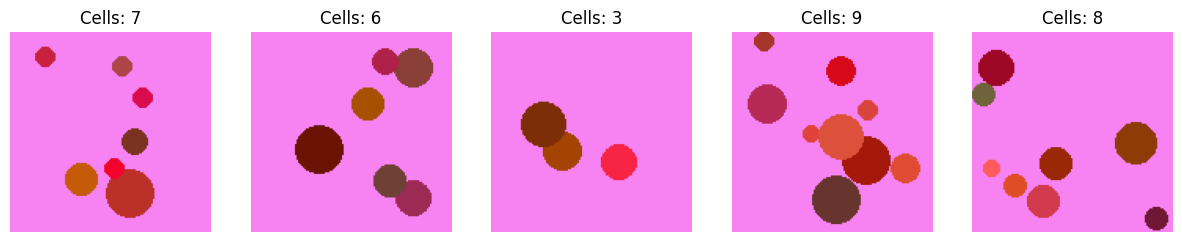

Episode: 1, Step: 1, State: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
weights [np.float64(1.1111098765445815), np.float64(1.1111098765445815), np.float64(1.1111098765445815), np.float64(1.1111098765445815), np.float64(1.1111098765445815), np.float64(1.1111098765445815), np.float64(1.1111098765445815), np.float64(1.1111098765445815), np.float64(1.1111098765445815), np.float64(1.1111098765445815)]
Episode: 1, Step: 1, Epsilon: 0.8958
Episode: 1, Step: 1, Action: [0.07939264 0.31243985 0.00717113 0.19001755 0.18106087 0.0302771
 0.05904087 0.01683785 0.04090358 0.08285857], Действие: случайное
loss =  tensor(2.2966, grad_fn=<NllLossBackward0>)
loss =  tensor(1.9427, grad_fn=<NllLossBackward0>)
loss =  tensor(1.7914, grad_fn=<NllLossBackward0>)
loss =  tensor(1.6072, grad_fn=<NllLossBackward0>)
loss =  tensor(1.6370, grad_fn=<NllLossBackward0>)
loss =  tensor(1.7327, grad_fn=<NllLossBackward0>)
loss =  tensor(1.7167, grad_fn=<NllLossBackward0>)
loss =  tensor(1.6161, grad_fn=<NllLossBackwa

KeyboardInterrupt: 

In [30]:
env = DataSelectionEnv()
actor = Actor(NUM_CLASSES, NUM_CLASSES)
critic = Critic(NUM_CLASSES)


visualize_data(env.train_data.images, env.train_data.labels)

actor_critic(env, actor, critic, episodes=10)
print("Training complete!")

In [ ]:
# Evaluate the trained CNN
test_dataset = DataPreloading().get_train_data() #Or, load a completely separate test dataset if you have one.

#Create test indices - fixed
test_indices = random.sample(range(len(test_dataset)), int(0.2*len(test_dataset))) #20% for test data
test_subset = Subset(test_dataset,test_indices)

test_dataloader = get_dataloader(test_subset, shuffle=False)
accuracy, error_per_class = env.evaluate(test_dataloader) # Reuse your existing evaluate function

print(f"Test Accuracy: {accuracy:.4f}")
print("Error per class:", error_per_class)

accuracy =  0.3429
Test Accuracy: 0.3429
Error per class: [0.009164969450101833, 0.7944936086529006, 0.748, 0.8336633663366336, 0.3026315789473684, 0.865, 0.9990157480314961, 0.8991097922848664, 0.9849699398797596, 0.0950920245398773]
